In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
import matplotlib.gridspec as gridspec
import numpy as np
import networkx as nx
import seaborn as sns

import os
import sys
sys.path.append(os.path.dirname(os.path.abspath('')))

from classes.agent import Agent
from classes.world import World
from classes.color_maps import ColorMaps
from classes.utils import *
from classes.news import News
from classes.agent import AgentState

In [2]:
def activate_agents(agents):
    for agent in agents.keys():
        agent.states[agents[agent]] = AgentState.ACTIVE

def news_cascade(agents, news):
    return sum([1 if a.states[news] == AgentState.ACTIVE else 0 for a in agents])
    
def find_degreecentral_nodes(world, k, blacklist, news):
    degree_centrality = []
    for _ in range(k):
        best = None
        bdeg = -1
        for a in world.graph.nodes():
            if world.agents[a] in degree_centrality or world.agents[a] in blacklist:
                continue
            d = world.graph.out_degree(a)
            if d > bdeg:
                bdeg = d
                best = world.agents[a]
        degree_centrality.append(best)
    s2 = {}
    for agent in degree_centrality:
        s2[agent] = news.name
    return s2
        
def full_dynamics(w, starting_points, n_iter=20):
    for d in starting_points.values():
        for agent in d.keys():
            agent.independence = 1.0 
    t = 0
    while t < n_iter:
        if t in starting_points.keys():
            activate_agents(starting_points[t])
        w.update(verbose=True)
        t += 1
    return (news_cascade(w.agents.values(), 0), news_cascade(w.agents.values(), 1))
            

In [3]:
def get_value(sensation1, sensation2, delay, n=100, samples=25, news_decay=0.0):
    #threshold = np.clip(np.random.normal(0.5, 0.1, n), 0.0, 1.0) #mu = 0.5, sigma = 0.1
    #independence = np.clip(np.random.normal(0.5, 0.1, n), 0.0, 1.0) #mu = 0.5, sigma = 0.1
    threshold = np.random.random(n)
    independence = np.random.random(n)
    names_agents = [_ for _ in range(n)]
    e = 0.0
    for s in range(samples):
        fake_news = News(0, sensation1, news_decay)
        counter_news = News(1, sensation2, news_decay)
        news_cycle = {fake_news.name: fake_news, counter_news.name: counter_news}
        w = construct_world(names_agents, threshold, independence, news_cycle)
        fakenews_spreader = find_degreecentral_nodes(w, 1, [], fake_news)
        counternews_spreader = find_degreecentral_nodes(w, 5, [a for a in fakenews_spreader.keys()], counter_news)
        starting_points = {0: fakenews_spreader, int(delay): counternews_spreader}
        c1, c2 = full_dynamics(w, starting_points)
        e += c1 - c2
    return e / samples

In [4]:
def calc_sensation_vs_sensation_vs_delay(sensations1, sensations2, delays, news_decay=0.0):
    s1 = len(sensations1)
    s2 = len(sensations2)
    d = len(delays)
    ratios = np.zeros((d,s1,s2))
    for k in range(d):
        for i in range(s1):
            for j in range(s2):
                ratios[k, i, j] = get_value(sensations[i], sensations[j], delays[k], news_decay=news_decay)
        print("=", end="", flush=True)
    print(" done")
    return ratios

In [5]:
sensations = np.linspace(0.1, 0.9, 5)
delays = [x for x in range(0, 9, 1)]
r = calc_sensation_vs_sensation_vs_delay(sensations, sensations, delays) #will take some time

========= done


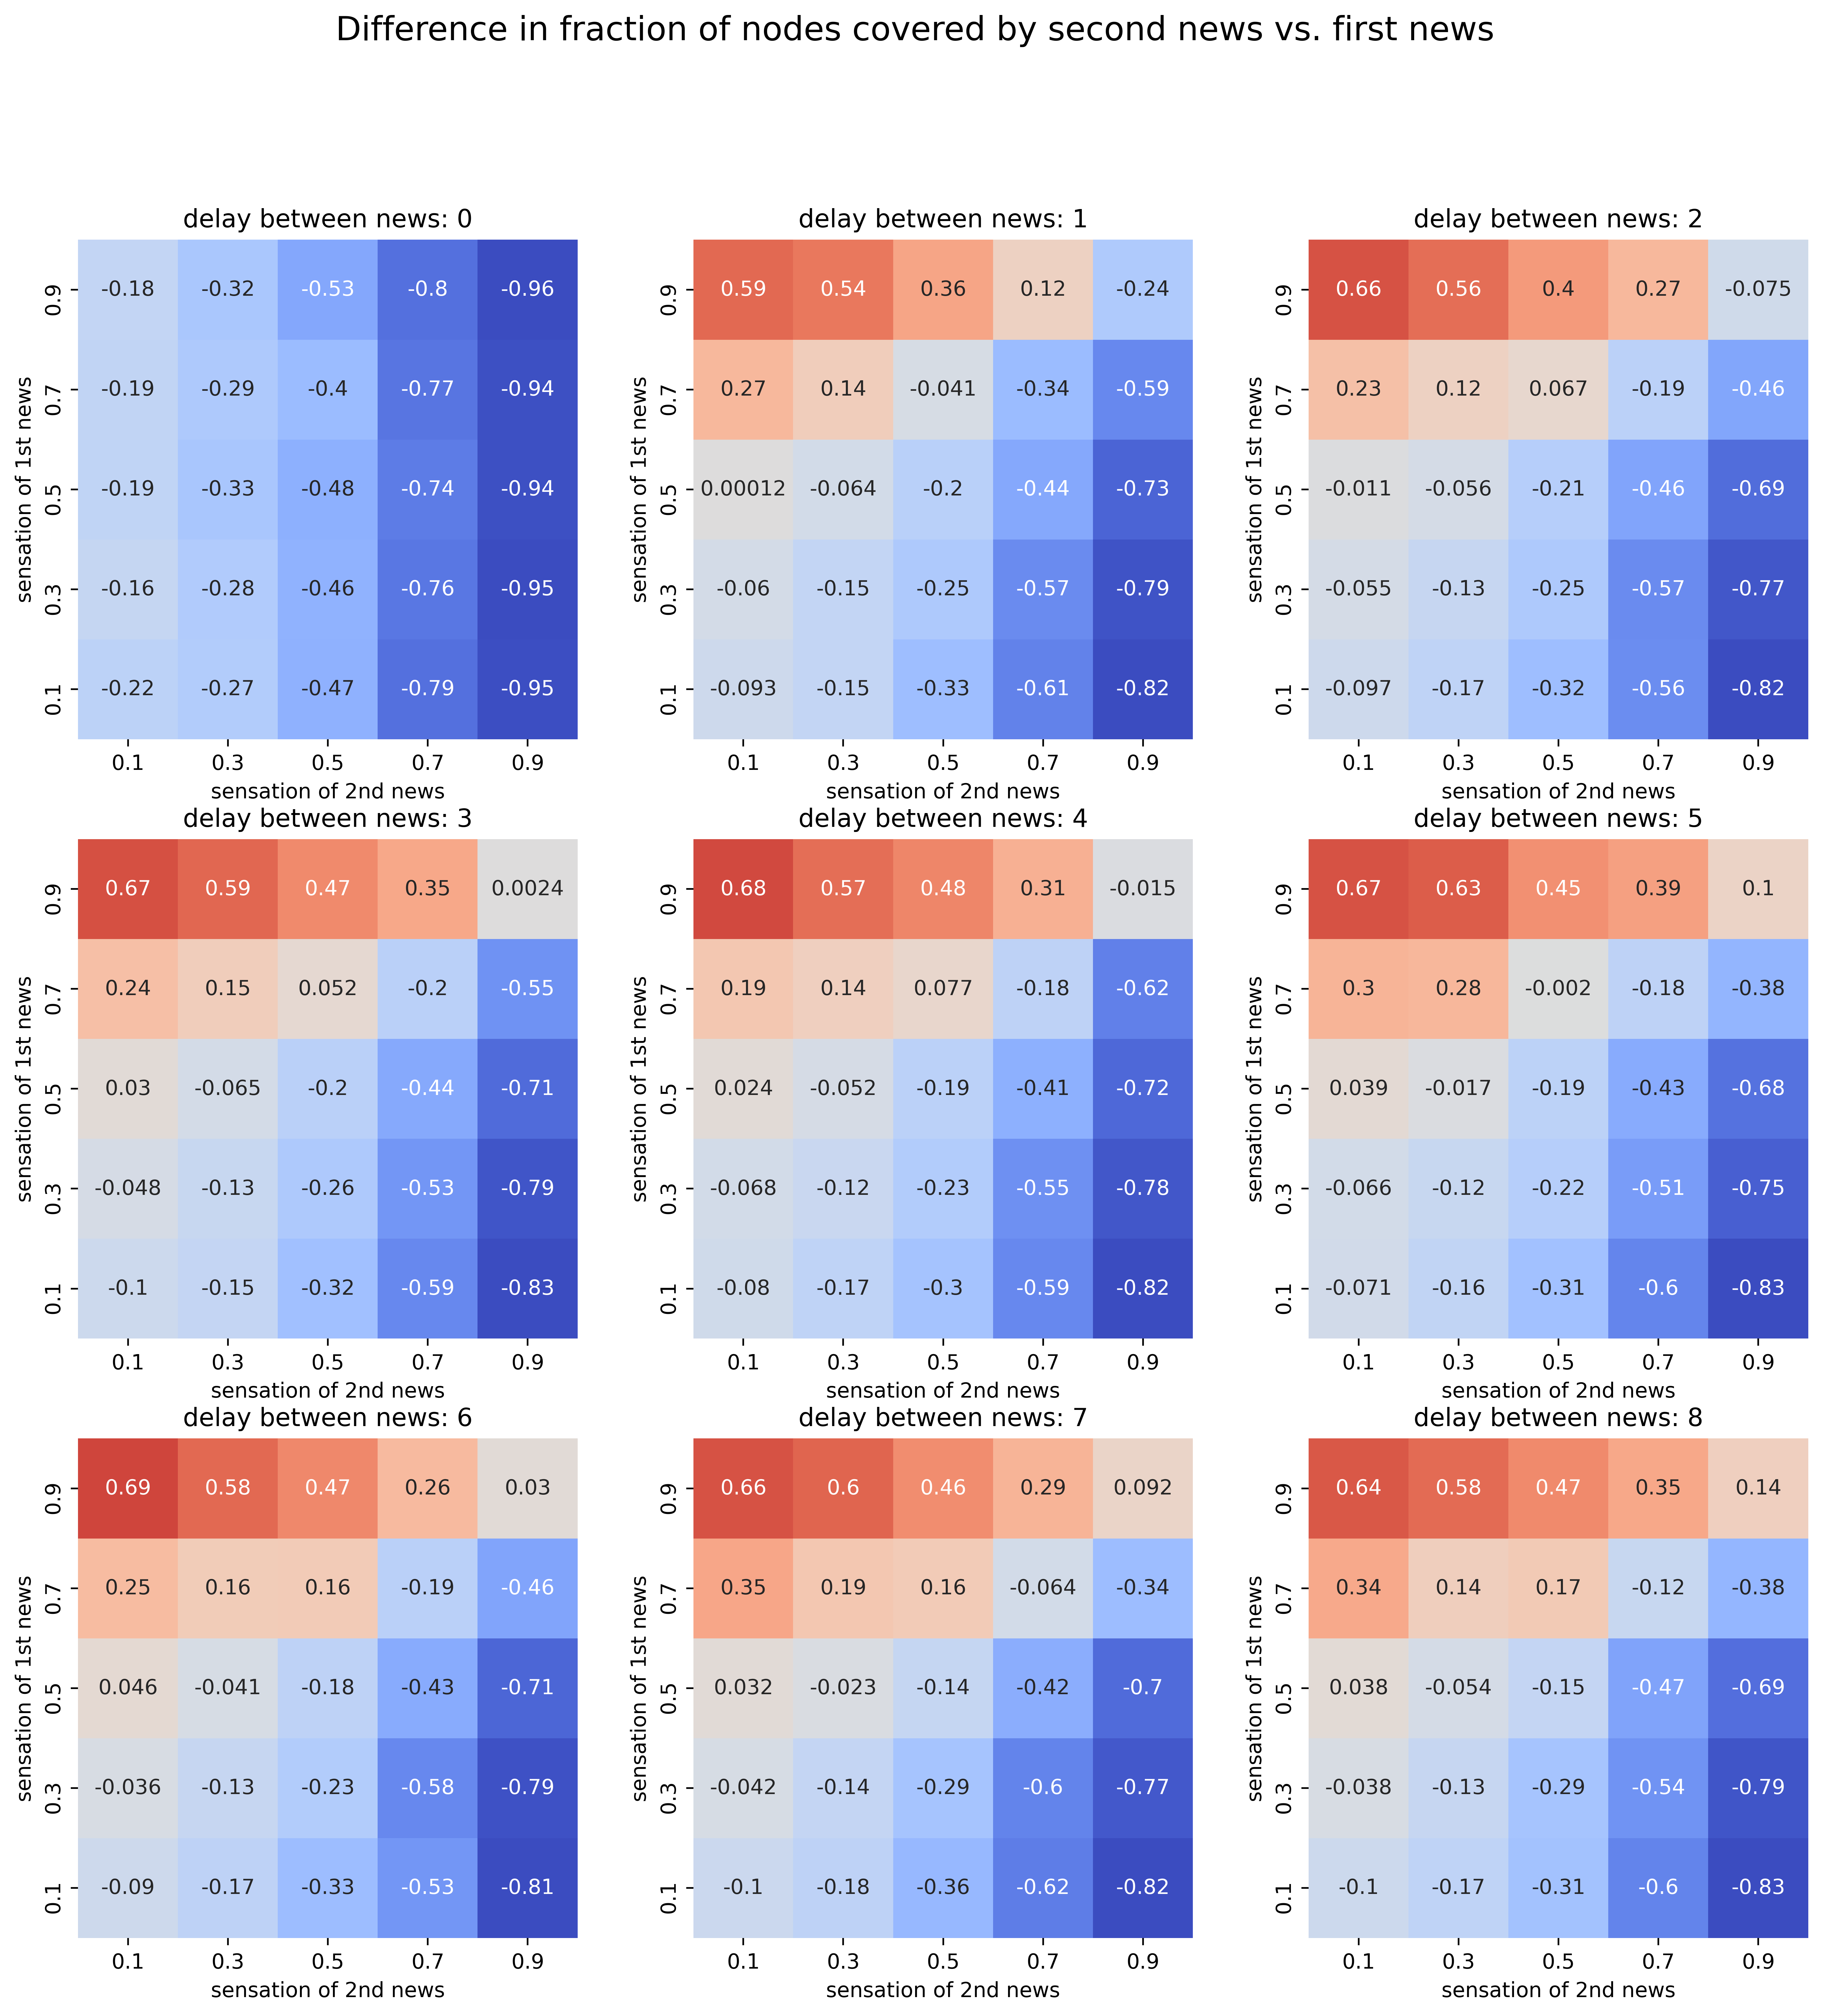

In [6]:
r = r / np.float32(100)
f = plt.figure(figsize=(15,15), dpi=500)
f.suptitle("Difference in fraction of nodes covered by second news vs. first news", fontsize=16)
for i in range(3):
    for j in range(3):
        d = 3*i + j
        if d >= len(delays): break
        ax = f.add_subplot(3, 3, d+1)
        ax = sns.heatmap(r[d], center=0.0, 
                         annot=True,
                         cmap="coolwarm", cbar=False,
                         xticklabels=np.float32(sensations), yticklabels=np.float32(sensations),
                         square = True)
        ax.set_ylabel("sensation of 1st news")
        ax.set_xlabel("sensation of 2nd news")
        ax.invert_yaxis()
        ax.set_title("delay between news: " + str(delays[d]))

In [7]:
sensations = np.linspace(0.1, 0.9, 5)
delays = [x for x in range(0, 9, 1)]
r = calc_sensation_vs_sensation_vs_delay(sensations, sensations, delays, news_decay=0.5) #now with decay

========= done


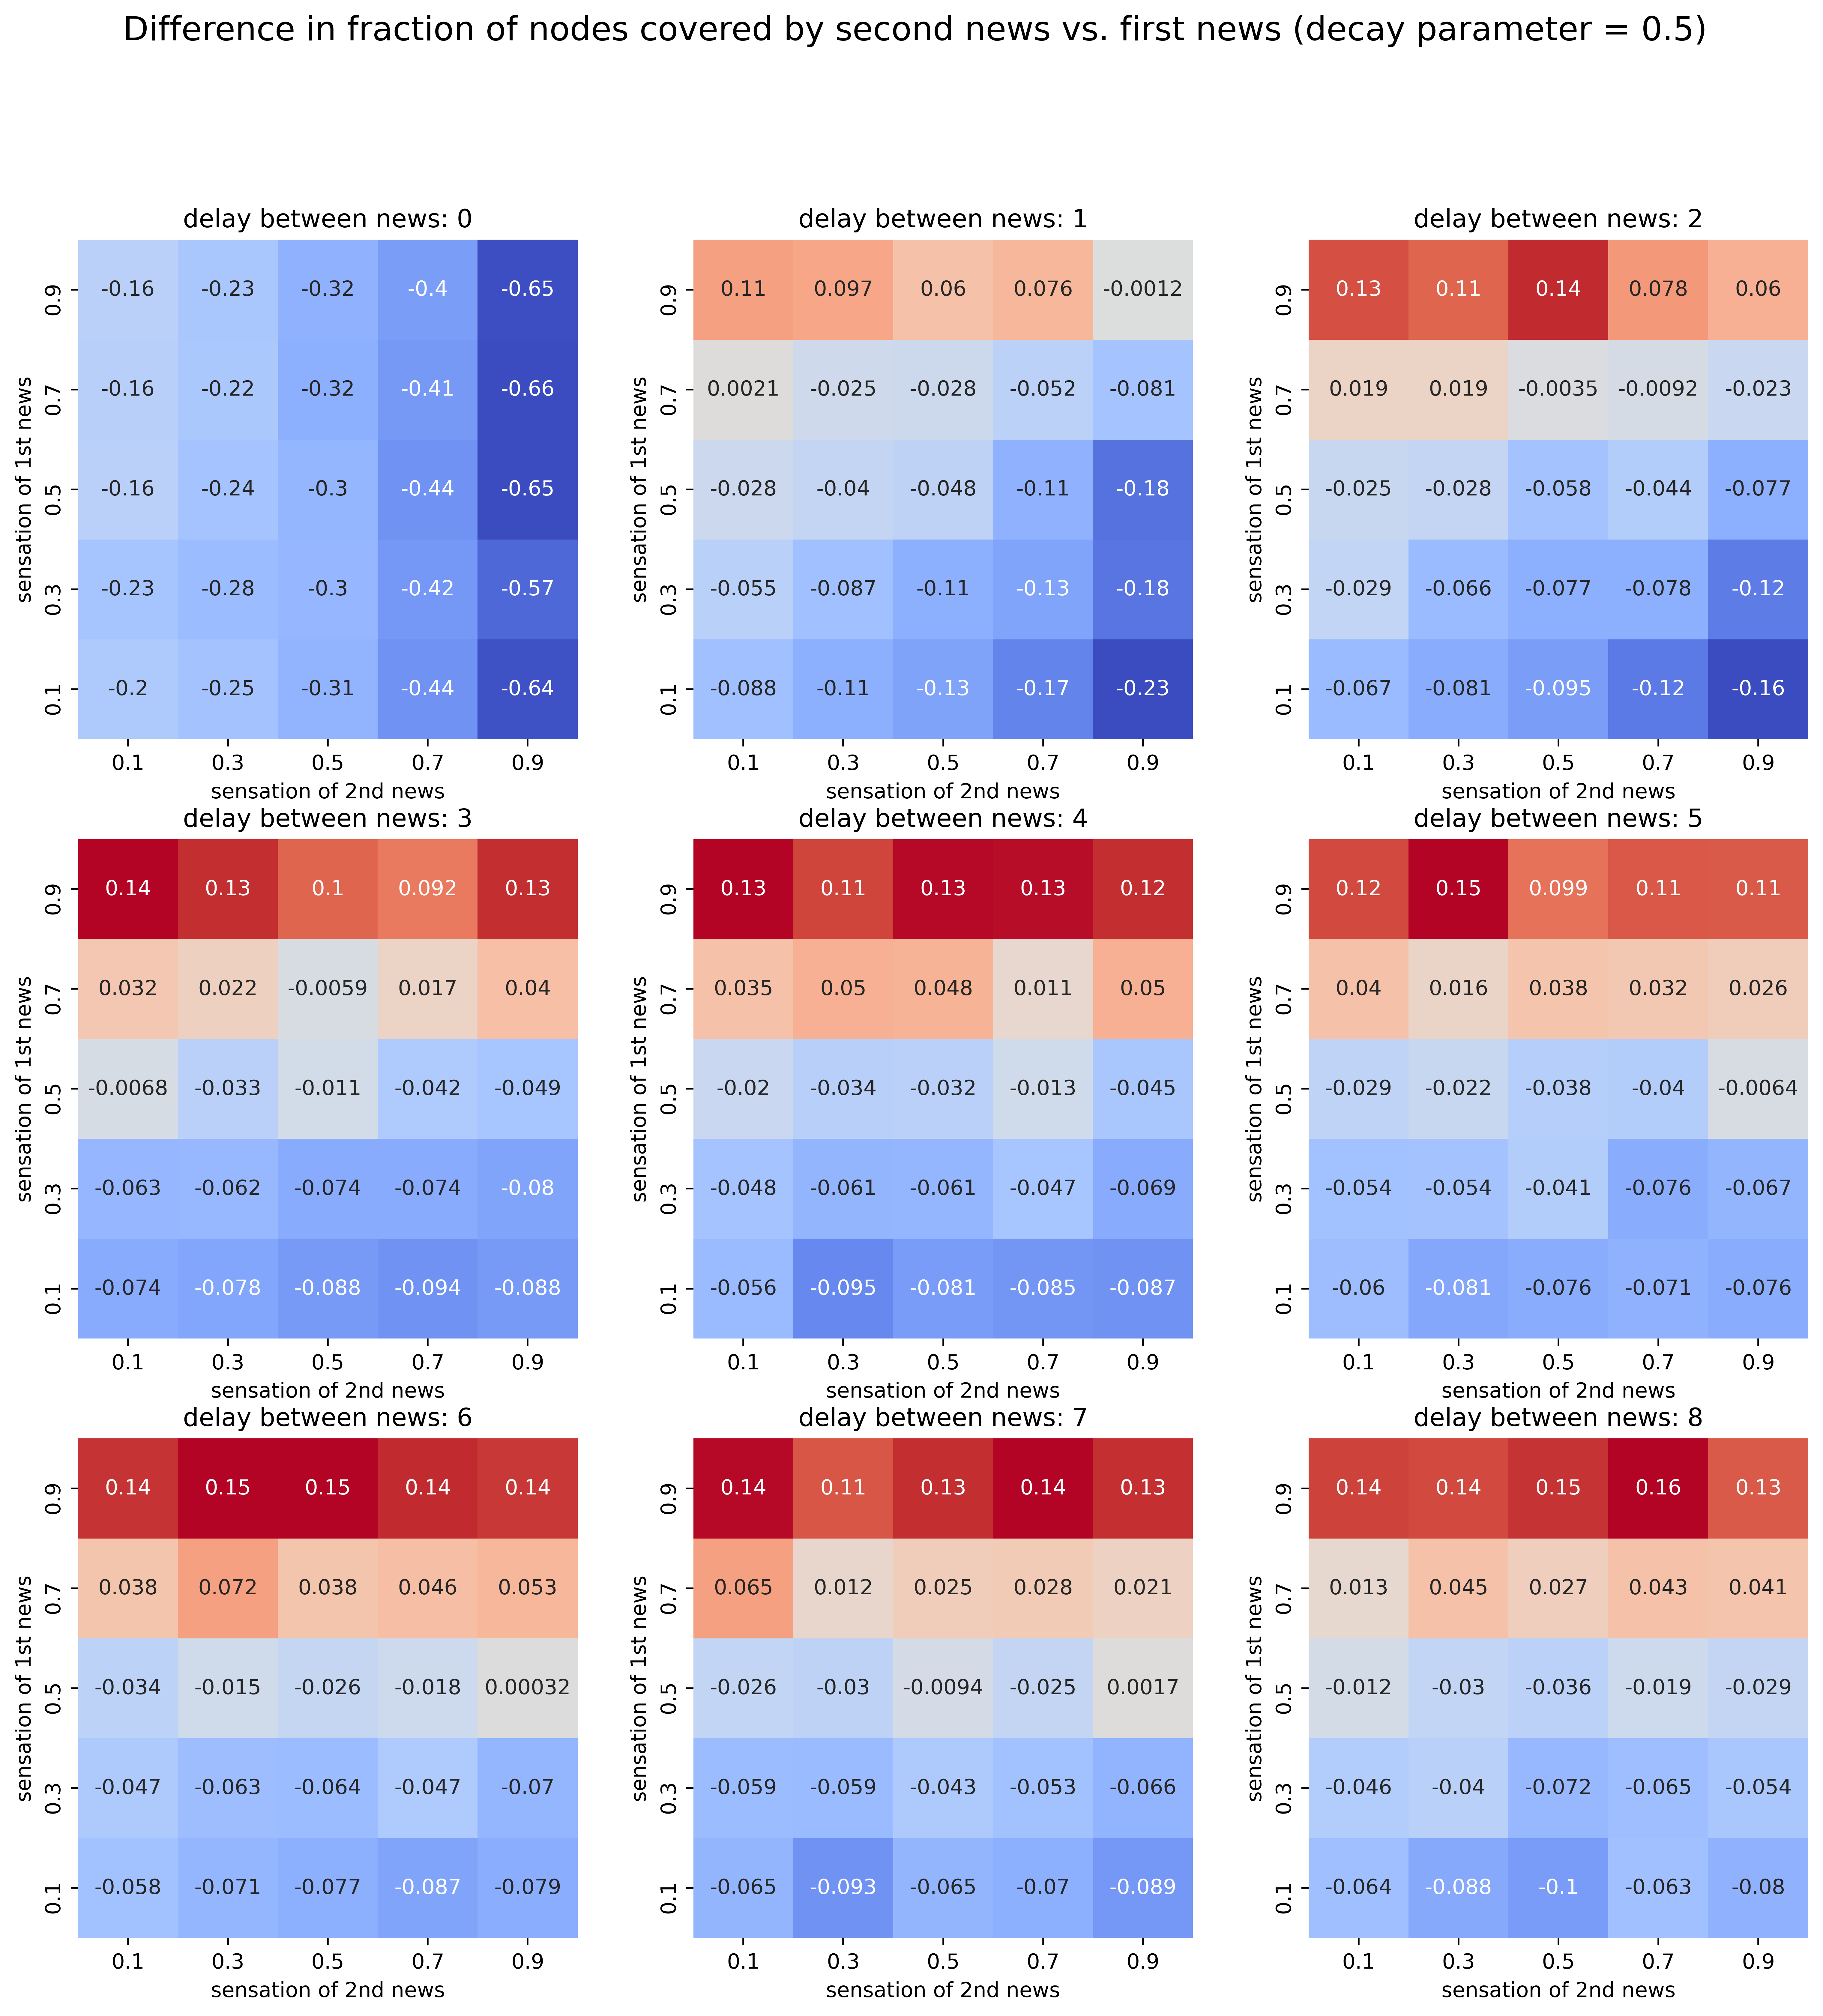

In [8]:
r = r / np.float32(100)
f2 = plt.figure(figsize=(15,15), dpi=500)
f2.suptitle("Difference in fraction of nodes covered by second news vs. first news (decay parameter = 0.5)", fontsize=16)
for i in range(3):
    for j in range(3):
        d = 3*i + j
        if d >= len(delays): break
        ax = f2.add_subplot(3, 3, d+1)
        ax = sns.heatmap(r[d], center=0.0, 
                         annot=True,
                         cmap="coolwarm", cbar=False,
                         xticklabels=np.float32(sensations), yticklabels=np.float32(sensations),
                         square = True)
        ax.set_ylabel("sensation of 1st news")
        ax.set_xlabel("sensation of 2nd news")
        ax.invert_yaxis()
        ax.set_title("delay between news: " + str(delays[d]))